In [75]:
import os
import pandas as pd
from kernels.wrapper import MODELS, KernelModelWrapper
from dataset.ipc2023_learning_domain_info import IPC2023_LEARNING_DOMAINS, get_test_ipc2023_learning_instance_files, get_best_bound
from itertools import product
from IPython.display import display, HTML
from util.scrape_log import scrape_search_log
from util.visualise import *

In [76]:
pd.options.display.float_format = "{:.1f}".format

In [77]:
_LOG_DIR = "logs/test_ipc2023"
_DIFFICULTIES = ["easy", "medium", "hard"]
_ITERATIONS = [str(i) for i in [1]]
_MODELS = ["linear-regression", "linear-svr", "ridge", "lasso"]
CONFIGS = list(product(_MODELS, _ITERATIONS))

In [78]:
def get_data(domain):
  data = {
  }

  test_files = get_test_ipc2023_learning_instance_files()

  for config in CONFIGS:
    d = {
      "solved": [],
      "expanded": [],
      "cost": [],
      "first_h": [],
      "quality": [],
      "c_opt": [],
    }
    model, iterations = config

    for difficulty in _DIFFICULTIES:
      for df, pf in test_files[domain]:
        if not difficulty in pf:  # TODO generalise
          continue
        pf_name = os.path.basename(pf).replace(".pddl", "")
        log_file = f"{_LOG_DIR}/{domain}_{difficulty}_{pf_name}_trained_models_kernel-{model}_llg_ipc2023-learning-{domain}_wl_{iterations}.joblib.log"
        
        if not os.path.exists(log_file):
          continue

        stats = scrape_search_log(log_file)
        for k in d:
          if k in stats:
            d[k].append(stats[k])
        
        c = stats["cost"]
        c_opt = get_best_bound(domain, difficulty, pf_name)
        quality = c_opt / c
        quality = max(quality, 0)
        d["quality"].append(quality)
        d["c_opt"].append(c_opt)
        
    data[config] = d

  return data

In [79]:
def get_metrics_df(data):
  d = {
    "config": [],
    "solved": [],
    "quality": [],
  }
  for config in CONFIGS:
    d["config"].append(config)
    d["solved"].append(sum(data[config]["solved"]))
    d["quality"].append(sum(data[config]["quality"]))
  return pd.DataFrame(d)

In [80]:
def get_table_df():
  d = {
    "domain": [],
  }
  for config in CONFIGS:
    d['_'.join(config)] = []

  sum_scores = {config: 0 for config in CONFIGS}

  for domain in IPC2023_LEARNING_DOMAINS:
    data = get_data(domain)
    d["domain"].append(domain)
    for config in CONFIGS:
      score = sum(data[config]["quality"])
      d['_'.join(config)].append(score)
      sum_scores[config] += score
  

  d["domain"].append("sum")
  for config in CONFIGS:
    d['_'.join(config)].append(sum_scores[config])

  return pd.DataFrame(d)

In [81]:
display(get_table_df())

,domain,linear-regression_1,linear-svr_1,ridge_1,lasso_1
0,blocksworld,5.3,17.8,16.8,22.2
1,childsnack,8.5,10.0,10.0,8.0
2,ferry,24.4,78.0,77.1,77.1
3,floortile,1.0,0.9,1.8,2.0
4,miconic,29.2,28.8,28.9,28.7
5,rovers,9.3,17.3,23.6,18.4
6,satellite,10.0,4.1,4.8,10.2
7,sokoban,21.8,34.8,36.6,36.6
8,spanner,25.9,25.9,30.0,30.0
9,transport,7.2,25.9,33.1,33.1


In [82]:
for domain in IPC2023_LEARNING_DOMAINS:
  print(domain)
  data = get_data(domain)
  display(get_metrics_df(data))

blocksworld


,config,solved,quality
0,"(linear-regression, 1)",6,5.3
1,"(linear-svr, 1)",27,17.8
2,"(ridge, 1)",29,16.8
3,"(lasso, 1)",36,22.2


childsnack


,config,solved,quality
0,"(linear-regression, 1)",9,8.5
1,"(linear-svr, 1)",10,10.0
2,"(ridge, 1)",10,10.0
3,"(lasso, 1)",8,8.0


ferry


,config,solved,quality
0,"(linear-regression, 1)",24,24.4
1,"(linear-svr, 1)",72,78.0
2,"(ridge, 1)",72,77.1
3,"(lasso, 1)",72,77.1


floortile


,config,solved,quality
0,"(linear-regression, 1)",1,1.0
1,"(linear-svr, 1)",1,0.9
2,"(ridge, 1)",2,1.8
3,"(lasso, 1)",2,2.0


miconic


,config,solved,quality
0,"(linear-regression, 1)",30,29.2
1,"(linear-svr, 1)",30,28.8
2,"(ridge, 1)",30,28.9
3,"(lasso, 1)",30,28.7


rovers


,config,solved,quality
0,"(linear-regression, 1)",10,9.3
1,"(linear-svr, 1)",25,17.3
2,"(ridge, 1)",29,23.6
3,"(lasso, 1)",19,18.4


satellite


,config,solved,quality
0,"(linear-regression, 1)",10,10.0
1,"(linear-svr, 1)",14,4.1
2,"(ridge, 1)",11,4.8
3,"(lasso, 1)",11,10.2


sokoban


,config,solved,quality
0,"(linear-regression, 1)",23,21.8
1,"(linear-svr, 1)",36,34.8
2,"(ridge, 1)",37,36.6
3,"(lasso, 1)",37,36.6


spanner


,config,solved,quality
0,"(linear-regression, 1)",30,25.9
1,"(linear-svr, 1)",30,25.9
2,"(ridge, 1)",30,30.0
3,"(lasso, 1)",30,30.0


transport


,config,solved,quality
0,"(linear-regression, 1)",8,7.2
1,"(linear-svr, 1)",33,25.9
2,"(ridge, 1)",30,33.1
3,"(lasso, 1)",30,33.1


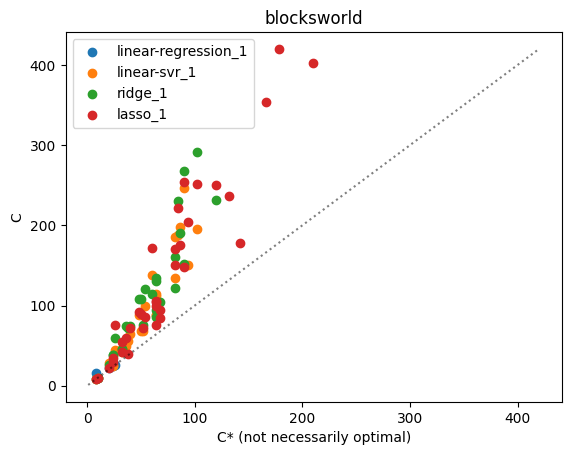

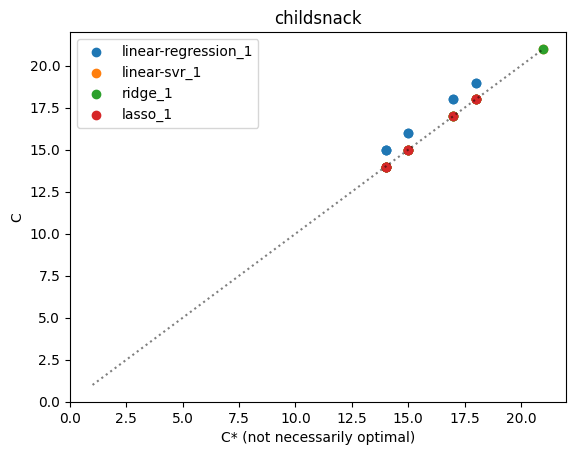

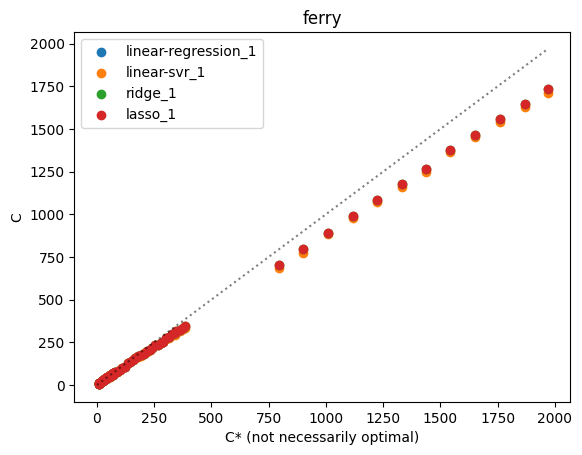

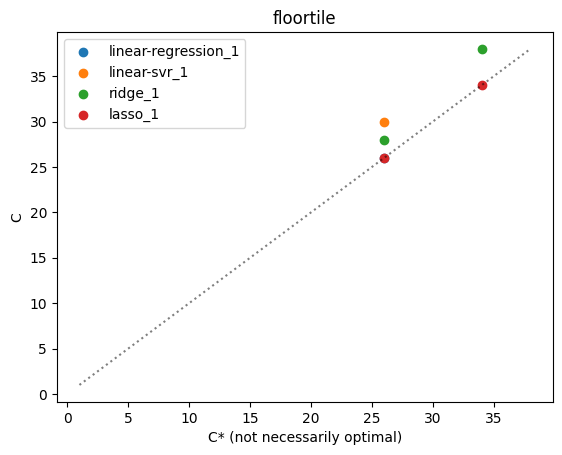

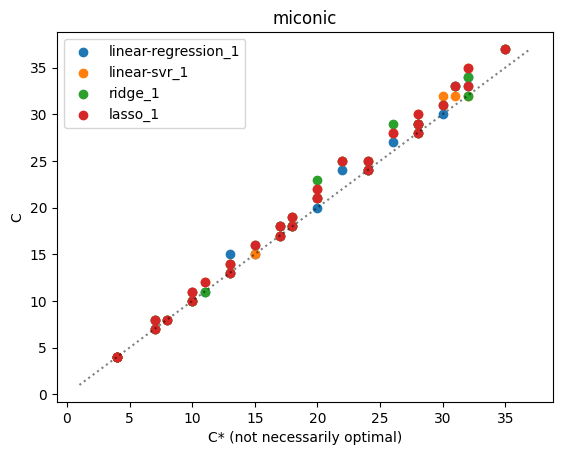

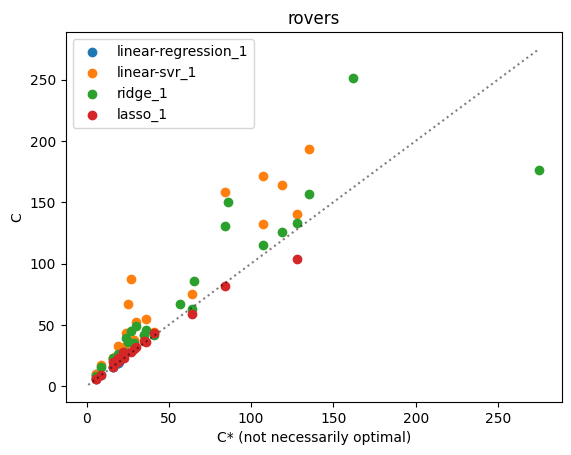

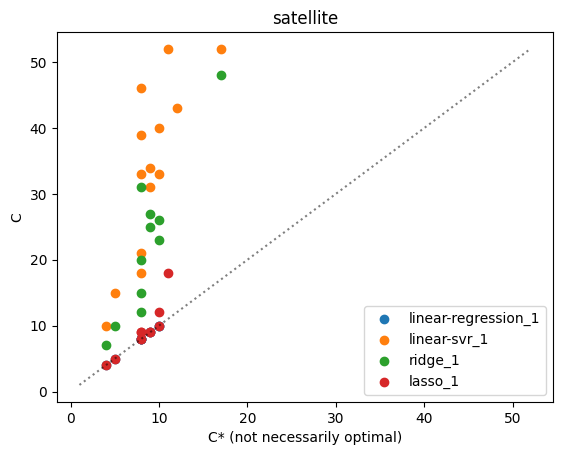

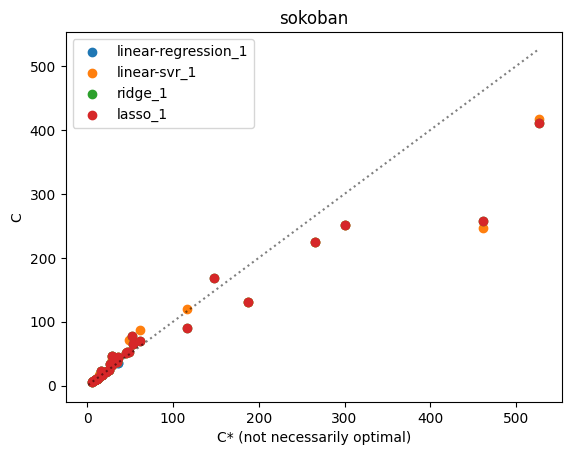

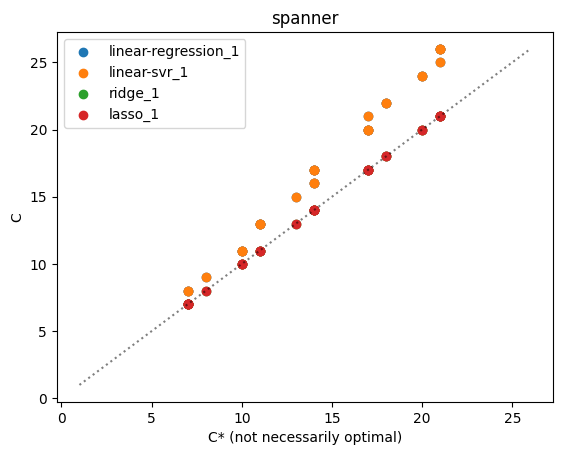

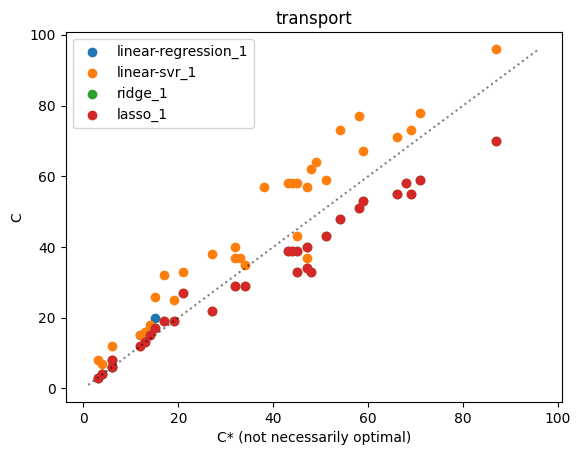

<Figure size 640x480 with 0 Axes>

In [83]:
for domain in IPC2023_LEARNING_DOMAINS:
  data = get_data(domain)

  max_val = 0

  for config in CONFIGS:
    cs = np.array(data[config]["cost"])
    c_opts = np.array(data[config]["c_opt"])
    index = np.where(cs != -1)
    cs = cs[index]
    c_opts = c_opts[index]
    plt.scatter(c_opts, cs, label="_".join(config))
    max_val = max([max_val, max(cs), max(c_opts)])
  
  plt.title(domain)
  plt.plot([1, max_val], [1, max_val], alpha=0.5, linestyle="dotted", c='k')
  plt.ylabel("C")
  plt.xlabel("C* (not necessarily optimal)")
  plt.legend()
  plt.show()
  os.makedirs("plots", exist_ok=True)
  plt.savefig(f"plots/ipc2023-learning-{domain}-cost.png")
  plt.clf()

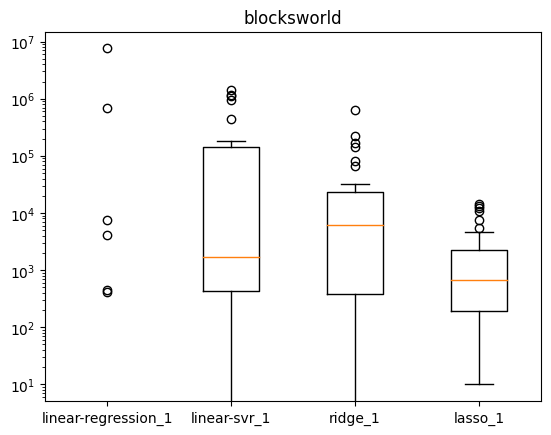

<Figure size 640x480 with 0 Axes>

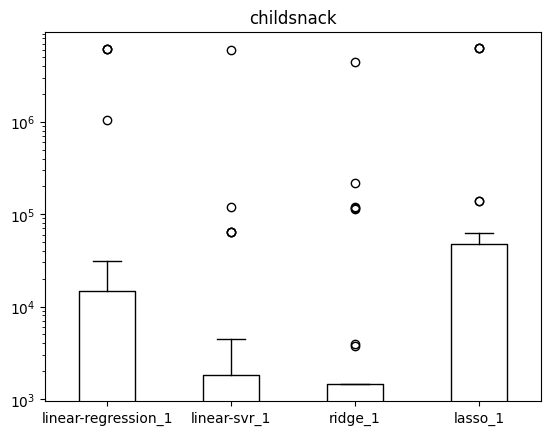

<Figure size 640x480 with 0 Axes>

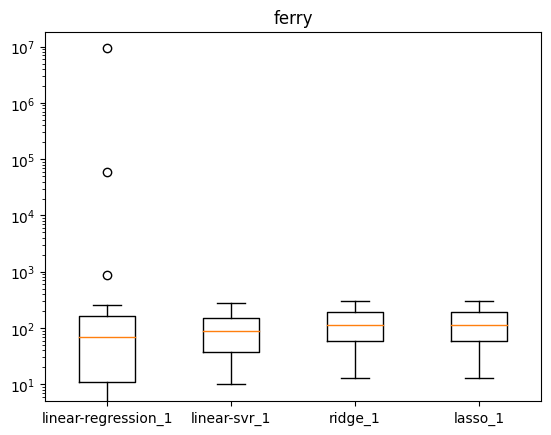

<Figure size 640x480 with 0 Axes>

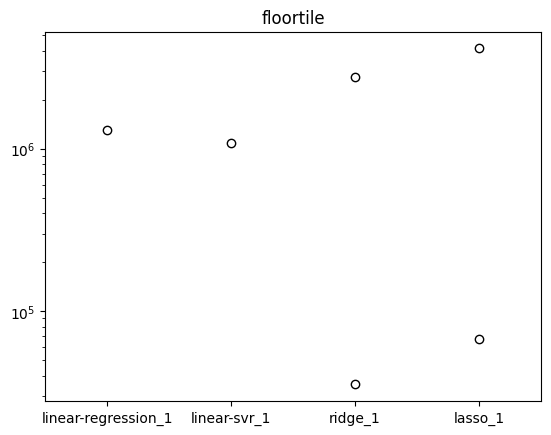

<Figure size 640x480 with 0 Axes>

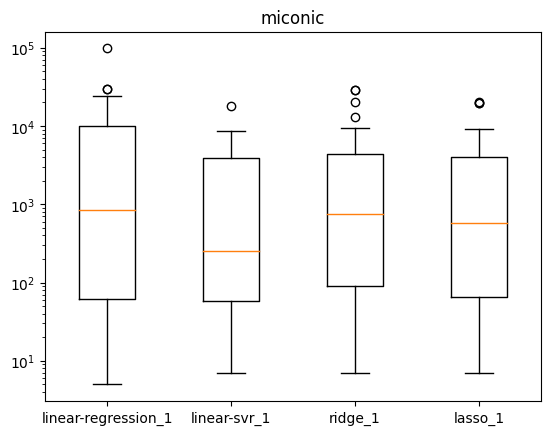

<Figure size 640x480 with 0 Axes>

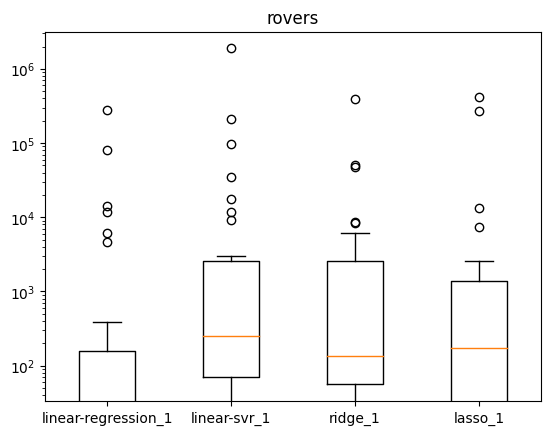

<Figure size 640x480 with 0 Axes>

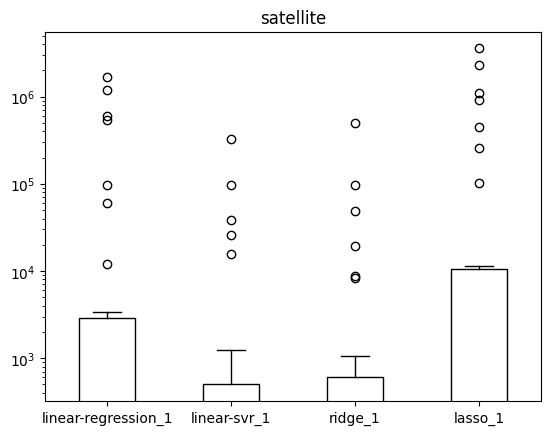

<Figure size 640x480 with 0 Axes>

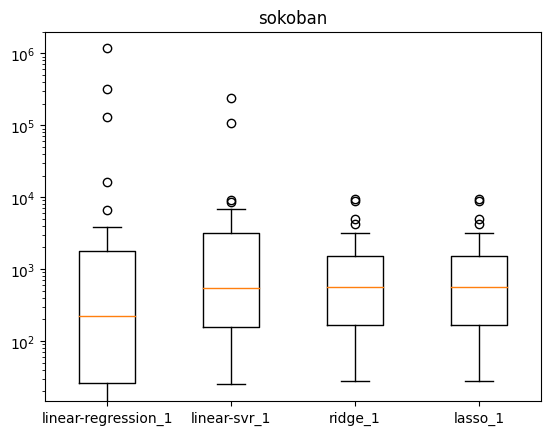

<Figure size 640x480 with 0 Axes>

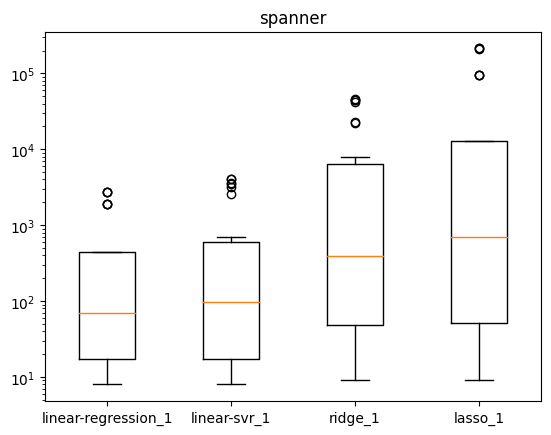

<Figure size 640x480 with 0 Axes>

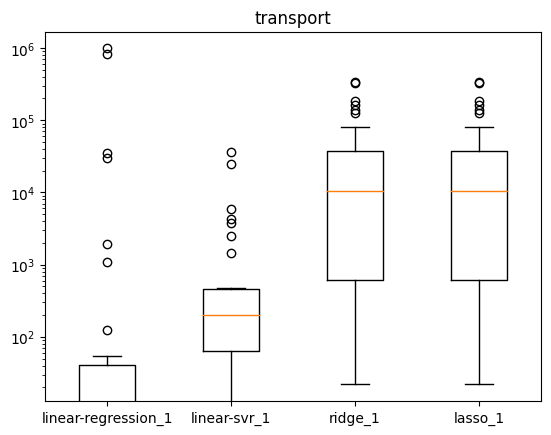

<Figure size 640x480 with 0 Axes>

In [88]:
for domain in IPC2023_LEARNING_DOMAINS:
  data = get_data(domain)

  max_val = 0

  my_dict = {}

  fig, ax = plt.subplots()

  for config in CONFIGS:
    expanded = np.array(data[config]["expanded"])
    # index = np.where(expanded != -1)
    expanded = expanded[index]
    my_dict["_".join(config)] = expanded
  
  plt.yscale("log")
  plt.title(domain)
  ax.boxplot(my_dict.values())
  ax.set_xticklabels(my_dict.keys())
  # plt.ylim(bottom=1)
  plt.show()
  os.makedirs("plots", exist_ok=True)
  plt.savefig(f"plots/ipc2023-learning-{domain}-expanded.png")
  plt.clf()